In [2]:
import scipy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utility_loader
from metrics import tf_counts_corr, tf_profile_auprc
from bpnetlite.performance import pearson_corr
from custom_bpnet import customBPNet
from tangermeme.ersatz import shuffle, dinucleotide_shuffle, randomize
from plotnine import *
import plotnine
import sklearn.metrics as skm
import tqdm
import seaborn as sns

# Set outdir
outdir = '/data/mariani/specificity_bpnet/output/models_hyperparams/calibrated_model/figs'

In [3]:
# Make predictions
test_data = utility_loader.bpnet_DataLoader(
	hdf5_tensor="/data/mariani/specificity_bpnet/folds/mtf2_only/fold_0/test_data_fold_0.hdf5", 
	in_window=6114, out_window=5000, random_state=0, num_workers=4, 
	batch_size=1024, max_jitter=0, reverse_complement=False
)

# Test data annot to do single TFs statistics
test_annot_regions = pd.read_csv("/data/mariani/specificity_bpnet/folds/mtf2_only/fold_0/test_data_fold_0_regions.csv")
# Dict architecture
dict_data = {
	"n_outputs":2,
	"n_control_tracks":2,
	"trimming":(6114-5000)//2, # difference between the input length and the output length, actually half of that.
	"alpha": 300, #0.5
	"n_filters": 128,
	"n_layers":13,
	"name": "5kb_test_mtf2_only"
}

# Loaded model
loaded_model = customBPNet(**dict_data).cuda()
loaded_model.load_state_dict(torch.load('/data/mariani/specificity_bpnet/code/5kb_test_mtf2_only.torch', weights_only = True))


# Predict
loaded_model.predict(
	test_data,batch_size=1024,
	shuffle_sequence=False, random_state=0, return_predictions=True
	)

Test MNLL	Test Profile Pearson	Test Count Pearson	Test Count MSE
3510.8943	0.2345505	0.3026145	0.7957


In [4]:
# Load predictions 
y_pred = np.load('/data/mariani/specificity_bpnet/code/5kb_test_mtf2_only.y_predProfile.npz')['arr_0']
y_obs = np.load('/data/mariani/specificity_bpnet/code/5kb_test_mtf2_only.y_obsProfile.npz')['arr_0']
y_counts = np.load('/data/mariani/specificity_bpnet/code/5kb_test_mtf2_only.y_predCounts.npz')['arr_0']
print(y_pred.shape)
print(y_obs.shape)

(652, 2, 5000)
(652, 2, 5000)


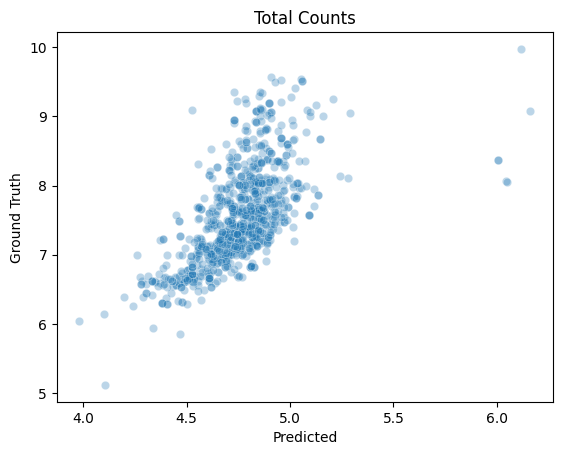

In [114]:
tf_idx =  test_annot_regions[test_annot_regions['name'] == 'ring1b'].index

x = y_counts[tf_idx,0]
y = np.log(y_obs.sum(axis=1).sum(axis=1)+1)[tf_idx]
sns.scatterplot(x=x, y=y, alpha=0.3)

plt.ylabel("Ground Truth")
plt.xlabel("Predicted")
plt.title("Total Counts")
plt.show()

In [4]:
y_profile = np.load("/data/mariani/specificity_bpnet/single_models/PROFILE.npz")
print(list(y_profile.keys()))
y_profile = y_profile["arr_0"]

y_counts = np.load("/data/mariani/specificity_bpnet/single_models/COUNTS.npz")
print(list(y_counts.keys()))
y_counts = y_counts["arr_0"]

print(y_profile.shape, y_counts.shape) 

# get ground truth
from tangermeme.io import extract_loci
import json

with open("../config_json/bpnet_train.json", "r") as f:
    parameters_fit = json.load(f)
    
with open("../config_json/bpnet_predict.json", "r") as f:
    parameters_predict = json.load(f)

parameters_fit['controls'] = None

valid_data = extract_loci(
    sequences=parameters_fit['sequences'],
    signals=parameters_fit['signals'],
    in_signals=parameters_fit['controls'],
    loci=parameters_predict['loci'],
    chroms=parameters_predict['chroms'],
    in_window=parameters_predict['in_window'],
    out_window=parameters_predict['out_window'],
    max_jitter=0,
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
    verbose=parameters_fit['verbose']
)
print(valid_data[0].shape, valid_data[1].shape) # sequences and signals

['arr_0']
['arr_0']
(410, 2, 5000) (410, 1)


Loading Loci: 100%|██████████| 410/410 [00:01<00:00, 311.42it/s]

torch.Size([410, 4, 6114]) torch.Size([410, 2, 5000])


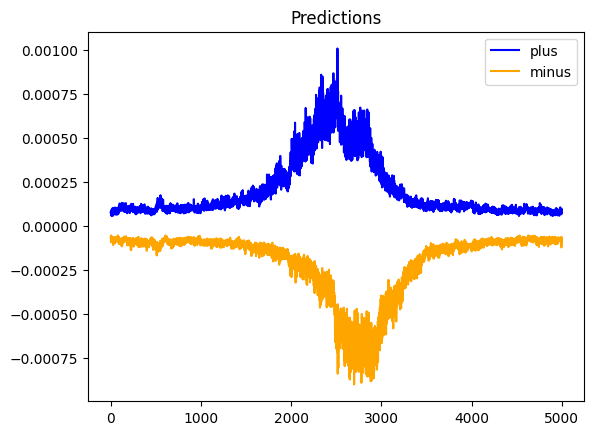

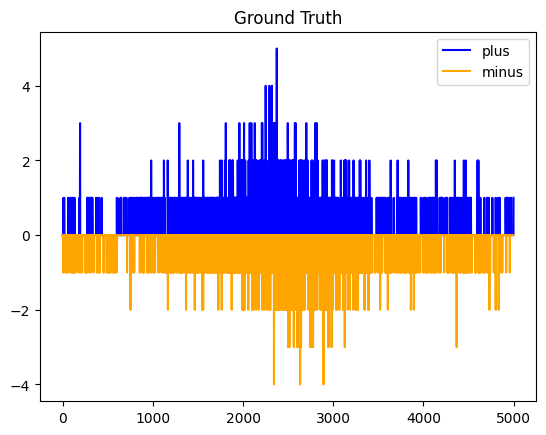

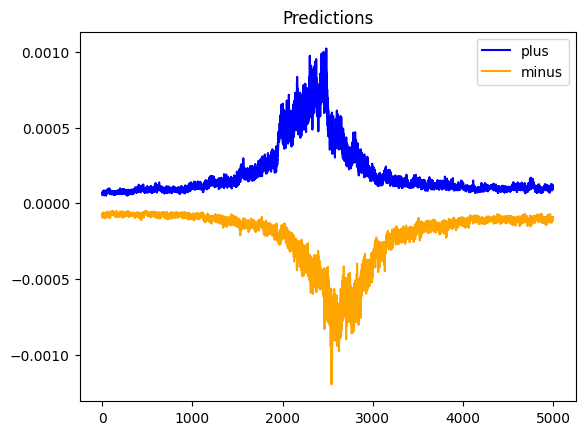

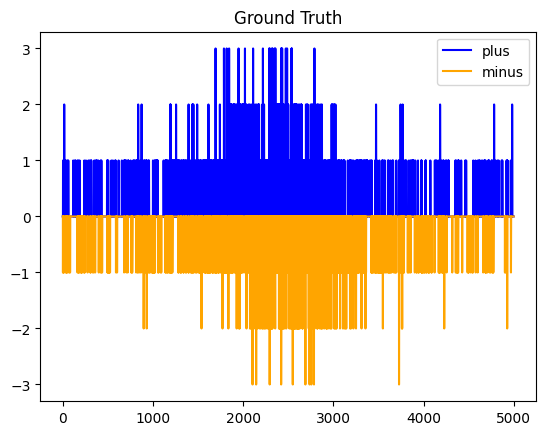

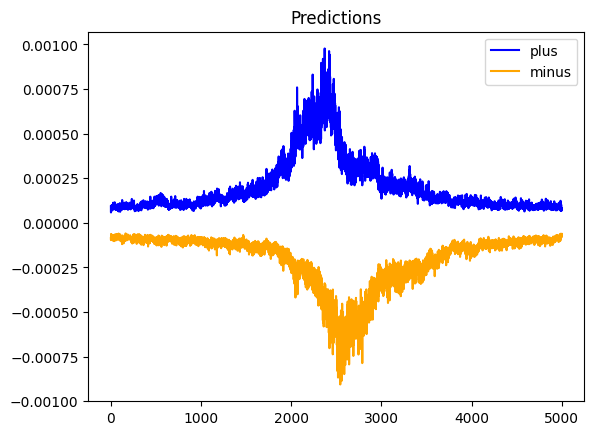

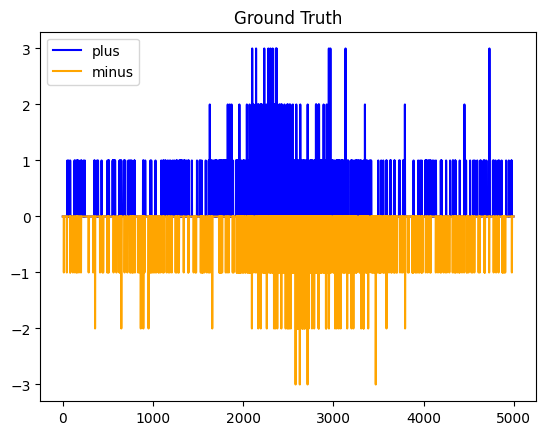

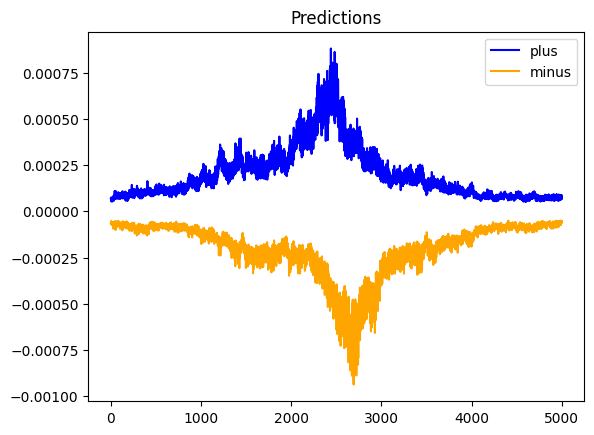

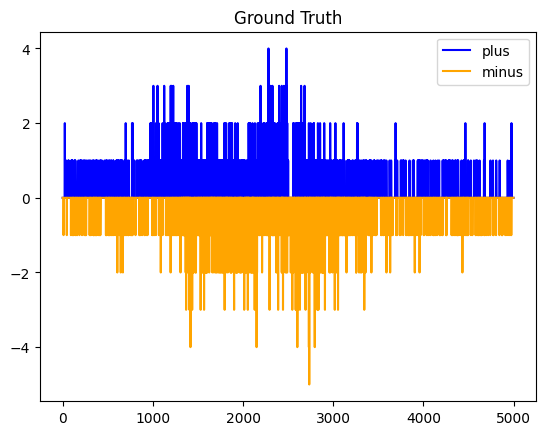

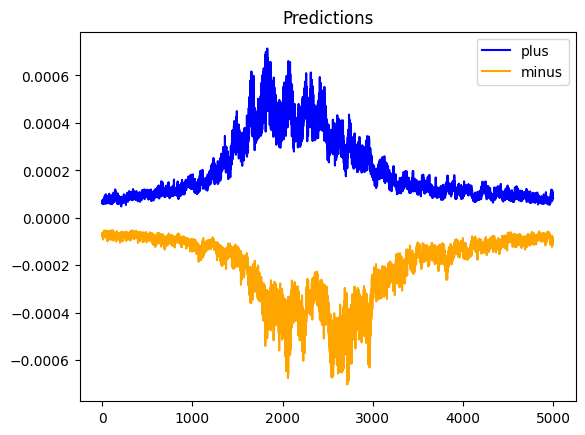

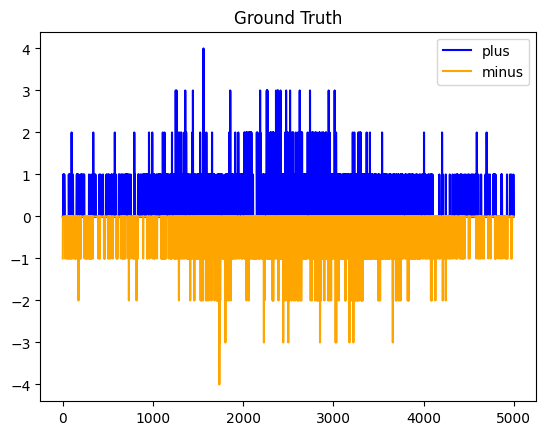

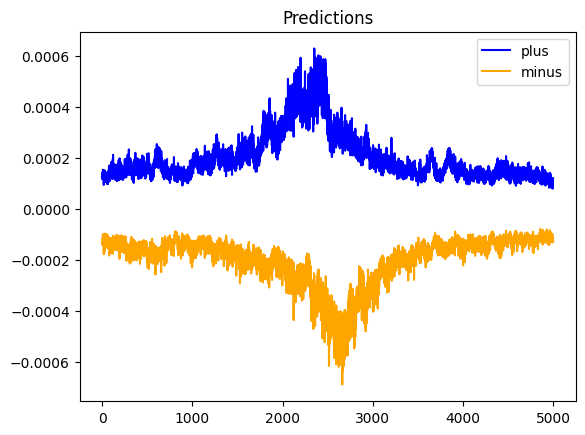

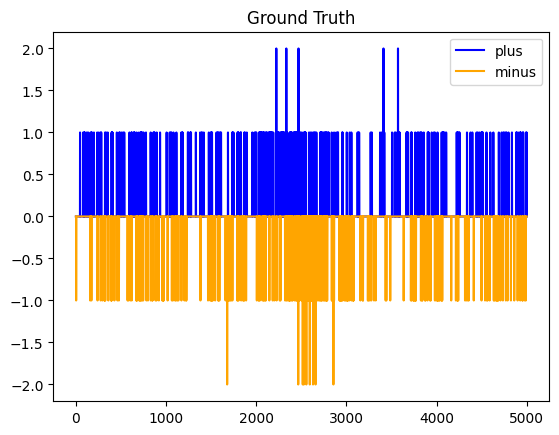

In [5]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
for i in range(0, 6):

	idx = i
	# predictions
	y = y_pred[idx, 0, :]
	y = softmax(y)
	x = np.arange(len(y))
	sns.lineplot(x=x, y=y, label="plus", color="blue")

	y = y_pred[idx, 1, :]
	y = softmax(y)
	x = np.arange(len(y))
	sns.lineplot(x=x, y=-y, label="minus", color="orange")
	plt.title("Predictions")
	plt.show()

	# ground truth
	y = y_obs[idx, 0, :]
	x = np.arange(len(y))
	sns.lineplot(x=x, y=y, label="plus", color="blue")

	y = y_obs[idx, 1, :]
	x = np.arange(len(y))
	sns.lineplot(x=x, y=-y, label="minus", color="orange")
	plt.title("Ground Truth")
	plt.show()